In [ ]:
from google.colab import files
files.upload()

Saving MS.csv to MS.csv


{'MS.csv': b'Date,Open,High,Low,Close,Volume\r\n4/1/2015 16:00:00,40.6,40.76,40.31,40.72,36865322\r\n4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476\r\n4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692\r\n4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375\r\n4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438\r\n4/9/2015 16:00:00,41.25,41.62,41.25,41.48,25723861\r\n4/10/2015 16:00:00,41.63,41.95,41.41,41.72,28022002\r\n4/13/2015 16:00:00,41.4,42.06,41.39,41.76,30276692\r\n4/14/2015 16:00:00,41.8,42.03,41.39,41.65,24244382\r\n4/15/2015 16:00:00,41.76,42.46,41.68,42.26,27343581\r\n4/16/2015 16:00:00,41.95,42.34,41.82,42.16,22509652\r\n4/17/2015 16:00:00,41.67,41.74,41.16,41.62,42387608\r\n4/20/2015 16:00:00,41.73,43.17,41.68,42.91,46057733\r\n4/21/2015 16:00:00,43,43.15,42.53,42.64,26013844\r\n4/22/2015 16:00:00,42.67,43.13,42.55,42.99,25064273\r\n4/23/2015 16:00:00,42.85,43.61,42.8,43.34,46309530\r\n4/24/2015 16:00:00,45.66,48.14,45.65,47.87,130933665\r\n4/27/2015 16:00:00,47.23,48.1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.impute import SimpleImputer
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df.rename(columns={'Date': 'Date', 'Open': 'Open', 'Close': 'Close', 'High': 'High', 'Low': 'Low'})
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    if df.isnull().values.any():
        print("Missing values found. Imputing missing values...")
        imputer = SimpleImputer(strategy='mean')
        df[['Open', 'Close', 'High', 'Low']] = imputer.fit_transform(df[['Open', 'Close', 'High', 'Low']])

    return df

def check_seasonality(ts):
    if len(ts) < 730:
        print("Warning: Insufficient data for seasonal decomposition.")
        return None
    else:
        decomposition = seasonal_decompose(ts, model='additive', period=365)
        return decomposition

def remove_seasonality(ts, decomposition):
    if decomposition:
        detrended = ts - decomposition.seasonal
    else:
        detrended = ts
    return detrended

def check_stationarity(ts):
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')
    return result[1] <= 0.05

def make_stationary(ts):
    diff_ts = ts.diff().dropna()
    is_stationary = check_stationarity(diff_ts)
    d = 1
    while not is_stationary:
        diff_ts = diff_ts.diff().dropna()
        is_stationary = check_stationarity(diff_ts)
        d += 1
    return diff_ts, d

def fit_arima_model(ts, d, max_p=5, max_q=5):
    p = q = range(0, max_p + 1)
    pdq = [(x, d, y) for x in p for y in q]

    best_aic = np.inf
    best_bic = np.inf
    best_order = None
    best_mdl = None

    for param in pdq:
        try:
            tmp_mdl = SARIMAX(ts, order=param, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
            tmp_aic = tmp_mdl.aic
            tmp_bic = tmp_mdl.bic
            if tmp_aic < best_aic and tmp_bic < best_bic:
                best_aic = tmp_aic
                best_bic = tmp_bic
                best_order = param
                best_mdl = tmp_mdl
        except: continue

    print(f"Best ARIMA order by AIC: {best_order}, AIC: {best_aic}")
    print(f"Best ARIMA order by BIC: {best_order}, BIC: {best_bic}")

    return best_mdl

def forecast_future_values(model_fit, original_last_value, periods):
    forecast = model_fit.get_forecast(steps=periods)
    forecast_mean = forecast.predicted_mean

    forecast_values = []
    last_value = original_last_value
    for value in forecast_mean:
        next_value = last_value + value
        forecast_values.append(next_value)
        last_value = next_value

    return pd.Series(forecast_values, index=pd.date_range(start=forecast_mean.index[0], periods=periods, freq='D'))

def suggest_action(forecasted_values):
    if all(forecasted_values.iloc[i] <= forecasted_values.iloc[i + 1] for i in range(len(forecasted_values) - 1)):
        return "buy"
    else:
        return "sell"

def check_residuals(model_fit):
    lb_test = acorr_ljungbox(model_fit.resid, lags=[10], return_df=True)
    return lb_test

def main(file_path, investment_days):
    df = load_data(file_path)

    columns_needed = ['Close']
    for col in columns_needed:
        if (col := df.get(col)) is None:
            print(f"Error: Column '{col}' not found in the dataset. Available columns: {df.columns}")
            return None

    ts_close = df['Close']

    decomposition_close = check_seasonality(ts_close)

    if decomposition_close:
        ts_close_detrended = remove_seasonality(ts_close, decomposition_close)
    else:
        ts_close_detrended = ts_close

    ts_close_log = np.log(ts_close_detrended)

    print("Checking stationarity of the time series:")
    is_stationary = check_stationarity(ts_close_log)
    if not is_stationary:
        print("Time series is not stationary. Differencing will be applied.")
        ts_close_stationary, d = make_stationary(ts_close_log)
    else:
        ts_close_stationary, d = ts_close_log, 0

    original_last_value = ts_close_log.iloc[-1]

    # Plot ACF and PACF before forecasting and reverse differencing
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plot_acf(ts_close_stationary, lags=20, ax=plt.gca(), title='ACF - Stationary Close Prices')

    plt.subplot(1, 2, 2)
    plot_pacf(ts_close_stationary, lags=20, ax=plt.gca(), title='PACF - Stationary Close Prices')

    plt.tight_layout()
    plt.show()

    print("Fitting ARIMA model for close prices:")
    model_fit_close = fit_arima_model(ts_close_stationary, d)

    forecasted_close_log = forecast_future_values(model_fit_close, original_last_value, investment_days)
    forecasted_close = np.exp(forecasted_close_log)

    initial_investment = 1000
    cumulative_return_close = calculate_cumulative_return(initial_investment, forecasted_close)

    print(f"Forecasted close price for next {investment_days} days:\n{forecasted_close}")
    suggestion = suggest_action(forecasted_close)
    print(f"Suggestion: {suggestion}")

    ljung_box_results = check_residuals(model_fit_close)
    print("Ljung-Box test results:")
    print(ljung_box_results)

    current_price = df['Close'].iloc[-1]
    num_stocks = int(input(f"Enter the number of stocks you want to buy based on today's price of Rs. {current_price:.2f}: "))

    investment = num_stocks * current_price
    print(f"Your investment based on today's price: Rs. {investment:.2f}")

    forecasted_last_price = forecasted_close.iloc[-1]

    if suggestion == "buy":
        returns = num_stocks * forecasted_last_price - investment
    else:
        profit_per_stock = abs(current_price - forecasted_last_price)
        returns = profit_per_stock * num_stocks + investment

    cumulative_return_after_investment = initial_investment + returns

    if suggestion == "buy":
        print(f"If you follow the suggestion to {suggestion}, your investment of Rs. {investment:.2f} would become Rs. {investment + returns:.2f} after {investment_days} days.")
    else:
        print(f"If you follow the suggestion to {suggestion}, your investment of Rs. {investment:.2f} would become Rs. {cumulative_return_after_investment:.2f} after {investment_days} days.")

    time_range = df.index

    plt.figure(figsize=(14, 12))

    plt.subplot(3, 1, 1)
    plt.plot(ts_close.index, ts_close, label='Original Close Prices')

    forecast_index = pd.date_range(start=ts_close.index[-1], periods=investment_days, freq='D')
    plt.plot(forecast_index, forecasted_close, color='red', label='Forecasted Close Prices')

    last_date = ts_close.index[-1] + pd.DateOffset(days=investment_days)
    plt.annotate(f"Rs. {forecasted_close.iloc[-1]:.2f}", xy=(last_date, forecasted_close.iloc[-1]), xytext=(-20, 10), textcoords='offset points', ha='center', fontsize=12)

    plt.legend()
    plt.title('Close Prices with Forecast')
    plt.xlim(time_range[0], last_date)

    plt.subplot(3, 1, 2)
    df['Short_MA'] = df['Close'].rolling(window=20).mean()
    df['Long_MA'] = df['Close'].rolling(window=50).mean()
    plt.plot(df.index, df['Close'], label='Close Price')
    plt.plot(df.index, df['Short_MA'], label='20-day MA', color='g')
    plt.plot(df.index, df['Long_MA'], label='50-day MA', color='m')

    plt.scatter(df.index[-1], df['Close'].iloc[-1], color='black', label='Current Close')
    plt.legend()
    plt.title('Moving Averages and Close Price')
    plt.xlim(time_range[0], last_date)

    # Subplot 3: AIC and BIC Values
    plt.subplot(3, 1, 3)
    aic_values = []
    bic_values = []
    orders = []

    p = q = range(0, 6)  # Adjust range as needed
    for p_val in p:
        for q_val in q:
            try:
                model = SARIMAX(ts_close, order=(p_val, d, q_val), enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit(disp=False)
                aic_values.append(model_fit.aic)
                bic_values.append(model_fit.bic)
                orders.append((p_val, d, q_val))
            except:
                continue

    orders_str = [f"{order[0]},{order[1]},{order[2]}" for order in orders]
    plt.plot(orders_str, aic_values, label='AIC', color='b')
    plt.plot(orders_str, bic_values, label='BIC', color='r')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title('AIC and BIC Values for Different ARIMA Orders')

    plt.tight_layout()
    plt.show()

    # Return forecasted values
    return forecasted_close.values

investment_days = int(input("Enter the number of days you want to invest in this stock: "))

forecasted_values = main('MS.csv', investment_days)

print("Forecasted values array:", forecasted_values)


Enter the number of days you want to invest in this stock: 20
Checking stationarity of the time series:
ADF Statistic: 0.07541386464558238
p-value: 0.964341837634295
Critical Value 1%: -3.4347582315402434
Critical Value 5%: -2.863486949792871
Critical Value 10%: -2.567806534528638
Time series is not stationary. Differencing will be applied.
ADF Statistic: -9.343211076788767
p-value: 8.684332334206774e-16
Critical Value 1%: -3.4347582315402434
Critical Value 5%: -2.863486949792871
Critical Value 10%: -2.567806534528638


Fitting ARIMA model for close prices:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best ARIMA order by AIC: (5, 1, 4), AIC: -7621.615044174502
Best ARIMA order by BIC: (5, 1, 4), BIC: -7568.456209129405
Forecasted close price for next 20 days:
1970-01-01 00:00:00.000001510    236.072253
1970-01-02 00:00:00.000001510    236.257761
1970-01-03 00:00:00.000001510    236.155843
1970-01-04 00:00:00.000001510    237.683253
1970-01-05 00:00:00.000001510    236.748928
1970-01-06 00:00:00.000001510    237.366438
1970-01-07 00:00:00.000001510    238.251424
1970-01-08 00:00:00.000001510    237.520955
1970-01-09 00:00:00.000001510    238.713287
1970-01-10 00:00:00.000001510    238.354421
1970-01-11 00:00:00.000001510    239.078923
1970-01-12 00:00:00.000001510    239.053261
1970-01-13 00:00:00.000001510    239.475472
1970-01-14 00:00:00.000001510    239.853928
1970-01-15 00:00:00.000001510    239.818977
1970-01-16 00:00:00.000001510    240.547557
1970-01-17 00:00:00.000001510    240.390233
1970-01-18 00:00:00.000001510    241.022378
1970-01-19 00:00:00.000001510    241.093638
197

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Forecasted values array: [236.07225346 236.25776139 236.15584253 237.68325337 236.7489277
 237.36643762 238.25142359 237.52095464 238.71328747 238.35442148
 239.0789229  239.0532614  239.47547168 239.85392842 239.81897683
 240.54755734 240.39023338 241.0223777  241.09363802 241.45818871]


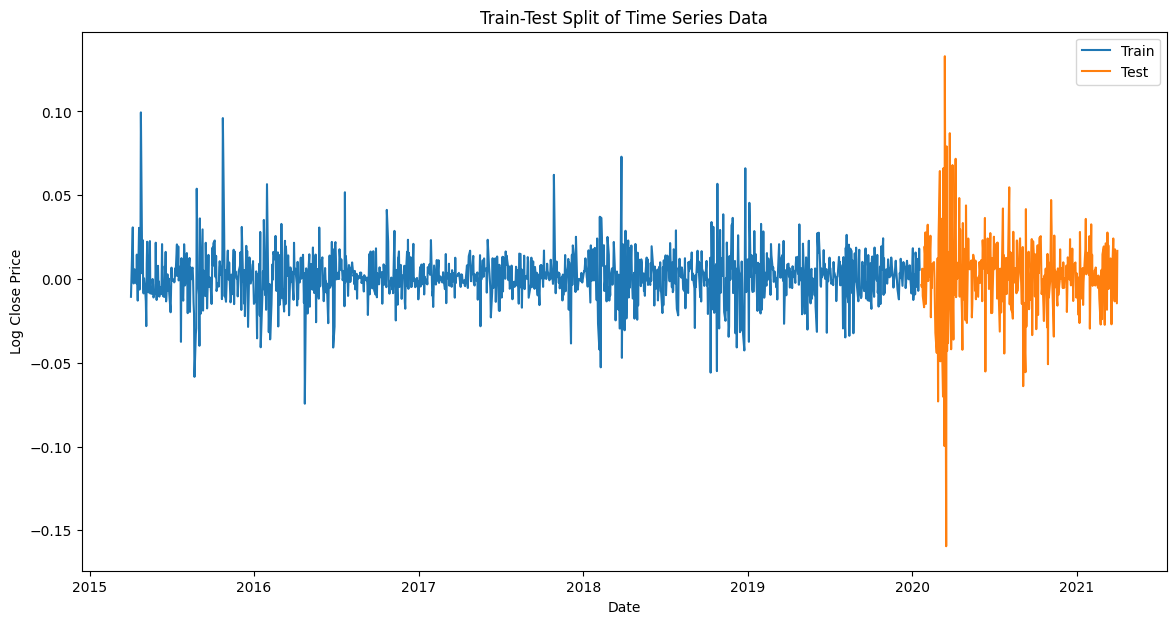

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Mean Squared Error on test data: 0.059874851812747584


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

def check_stationarity(ts):
    result = adfuller(ts)
    return result[1] <= 0.05

def make_stationary(ts):
    diff_ts = ts.diff().dropna()
    is_stationary = check_stationarity(diff_ts)
    d = 1
    while not is_stationary:
        diff_ts = diff_ts.diff().dropna()
        is_stationary = check_stationarity(diff_ts)
        d += 1
    return diff_ts, d

def fit_arima_model(ts, d, max_p=5, max_q=5):
    p = q = range(0, max_p + 1)
    pdq = [(x, d, y) for x in p for y in q]
    best_aic = np.inf
    best_order = None
    best_mdl = None

    for param in pdq:
        try:
            tmp_mdl = SARIMAX(ts, order=param, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = param
                best_mdl = tmp_mdl
        except:
            continue
    return best_mdl

def forecast_future_values(model_fit, original_last_value, periods):
    forecast = model_fit.get_forecast(steps=periods)
    forecast_mean = forecast.predicted_mean
    forecast_values = []
    last_value = original_last_value
    for value in forecast_mean:
        next_value = last_value + value
        forecast_values.append(next_value)
        last_value = next_value
    return pd.Series(forecast_values, index=pd.date_range(start=forecast_mean.index[0], periods=periods, freq='D'))

def main(file_path):
    df = load_data(file_path)
    ts_close = df['Close']
    ts_close_log = np.log(ts_close)
    is_stationary = check_stationarity(ts_close_log)
    if not is_stationary:
        ts_close_stationary, d = make_stationary(ts_close_log)
    else:
        ts_close_stationary, d = ts_close_log, 0

    # Train-test split
    train_size = int(len(ts_close_stationary) * 0.8)
    train_ts, test_ts = ts_close_stationary[:train_size], ts_close_stationary[train_size:]

    original_last_value = train_ts.iloc[-1]

    # Plot train-test split
    plt.figure(figsize=(14, 7))
    plt.plot(train_ts, label='Train')
    plt.plot(test_ts, label='Test')
    plt.title('Train-Test Split of Time Series Data')
    plt.xlabel('Date')
    plt.ylabel('Log Close Price')
    plt.legend()
    plt.show()

    # Fit ARIMA model
    model_fit_close = fit_arima_model(train_ts, d)

    # Forecast
    forecasted_close_log = forecast_future_values(model_fit_close, original_last_value, len(test_ts))
    forecasted_close = np.exp(forecasted_close_log)

    # Calculate MSE
    test_ts_exp = np.exp(test_ts)
    mse = mean_squared_error(test_ts_exp, forecasted_close)
    print(f"Mean Squared Error on test data: {mse}")

main('MS.csv')


In [ ]:
pip install tensorflow

In [ ]:
pip install fbprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 28.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.api import VAR

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    if df.isnull().values.any():
        print("Missing values found. Imputing missing values...")
        df.fillna(method='ffill', inplace=True)

    return df

def create_lstm_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def suggest_action(forecasted_values, current_price):
    if current_price > forecasted_values[-1]:
        return "sell"
    elif current_price < forecasted_values[-2]:
        return "buy"
    elif all(forecasted_values[i] <= forecasted_values[i + 1] for i in range(len(forecasted_values) - 1)):
        return "buy"
    else:
        return "sell"

def forecast_with_var(df, investment_days):
    model = VAR(df)
    model_fit = model.fit()
    forecast = model_fit.forecast(model_fit.endog[-model_fit.k_ar:], steps=investment_days)
    forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=df.index[-1], periods=investment_days+1, freq='B')[1:], columns=df.columns)
    return forecast_df

def forecast_with_lstm(model, X_test, scaler, time_step, investment_days, last_date):
    lstm_forecasted_values = []
    x_input = X_test[-1]
    for _ in range(investment_days):
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        lstm_forecasted_values.append(yhat[0][0])
        x_input = np.append(x_input[:, 1:, :], yhat.reshape((1, 1, 1)), axis=1)

    lstm_forecasted_values = scaler.inverse_transform(np.array(lstm_forecasted_values).reshape(-1, 1)).flatten()
    forecasted_dates = pd.date_range(start=last_date, periods=investment_days+1, freq='B')[1:]
    lstm_forecast_df = pd.DataFrame(lstm_forecasted_values, index=forecasted_dates, columns=['Close'])
    return lstm_forecast_df

def main(file_path, investment_days):
    df = load_data(file_path)
    ts_close = df[['Close']].values

    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    ts_close_scaled = scaler.fit_transform(ts_close)

    # Create LSTM dataset
    time_step = 60
    X, Y = create_lstm_dataset(ts_close_scaled, time_step)

    # Split into train and test sets
    training_size = int(len(X) * 0.8)
    X_train, X_test = X[:training_size], X[training_size:]
    Y_train, Y_test = Y[:training_size], Y[training_size:]

    # Reshape for LSTM [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Build and train LSTM model
    model = build_lstm_model((X_train.shape[1], 1))
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, batch_size=64, verbose=1, callbacks=[early_stopping])

    # Predict and inverse transform
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Calculate MSE
    mse = mean_squared_error(scaler.inverse_transform(Y_test.reshape(-1, 1)), test_predict)
    print(f'Mean Squared Error (MSE) for LSTM model: {mse:.2f}')

    # Forecasted values using LSTM
    last_date = df.index[-1]
    lstm_forecast_df = forecast_with_lstm(model, X_test, scaler, time_step, investment_days, last_date)

    # VAR forecasting for 'Close' and 'Volume'
    forecasted_df = forecast_with_var(df[['Close', 'Volume']], investment_days)
    var_forecasted_close = forecasted_df['Close'].values
    var_forecasted_volume = forecasted_df['Volume'].values

    # Combine forecasted values
    combined_forecasted_values = (lstm_forecast_df['Close'].values + var_forecasted_close) / 2.0

    # Suggest action based on combined forecasted values
    suggestion = suggest_action(combined_forecasted_values, df['Close'].iloc[-1])
    print(f"Suggestion: {suggestion}")

    # Calculate investment based on current price and combined forecasted values
    current_price = df['Close'].iloc[-1]
    num_stocks = int(input(f"Enter the number of stocks you want to buy based on today's price of Rs. {current_price:.2f}: "))

    investment = num_stocks * current_price
    print(f"Your investment based on today's price: Rs. {investment:.2f}")

    forecasted_last_price = combined_forecasted_values[-1]

    if suggestion == "buy":
        returns = num_stocks * forecasted_last_price - investment
    else:
        profit_per_stock = abs(current_price - forecasted_last_price)
        returns = profit_per_stock * num_stocks + investment

    cumulative_return_after_investment = investment + returns

    if suggestion == "buy":
        print(f"If you follow the suggestion to {suggestion}, your investment of Rs. {investment:.2f} would become Rs. {investment + returns:.2f} after {investment_days} days.")
    else:
        print(f"If you follow the suggestion to {suggestion}, your investment of Rs. {investment:.2f} would become Rs. {cumulative_return_after_investment:.2f} after {investment_days} days.")

    # Plot results
    plt.figure(figsize=(14, 8))
    plt.plot(df.index, df['Close'], label='Original Close Prices')

    # Plot train predictions
    train_predict_plot = np.empty_like(ts_close)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
    plt.plot(df.index, train_predict_plot, label='Train Predictions')

    # Plot test predictions
    test_predict_plot = np.empty_like(ts_close)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict) + time_step:len(ts_close) - 1, :] = test_predict
    plt.plot(df.index, test_predict_plot, label='Test Predictions')

    # Plot combined forecasted values
    forecasted_dates = pd.date_range(df.index[-1], periods=investment_days + 1, freq='B')[1:]  # Generating future dates
    plt.plot(forecasted_dates, combined_forecasted_values, label=f'Combined Forecasted Close Prices for next {investment_days} days', linestyle='--', color='green')

    plt.axvline(x=df.index[training_size + time_step], color='r', linestyle='--', label='Train/Test Split')
    plt.legend()
    plt.title('Forecasting Stock Prices using LSTM and VAR')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.grid(True)
    plt.show()

    print(f"LSTM Forecasted close prices for the next {investment_days} days:\n{lstm_forecast_df['Close'].values}")
    print(f"VAR Forecasted close prices for the next {investment_days} days:\n{var_forecasted_close}")
    print(f"Combined Forecasted close prices for the next {investment_days} days:\n{combined_forecasted_values}")

    return lstm_forecast_df, forecasted_df, combined_forecasted_values

# Main execution
investment_days = int(input("Enter the number of days you want to invest in this stock: "))
lstm_forecast_df, var_forecast_df, combined_forecasted_values = main('MS.csv', investment_days)


Enter the number of days you want to invest in this stock: 21
Epoch 1/200
19/19 [==============================] - 12s 265ms/step - loss: 0.0092 - val_loss: 0.0017
Epoch 2/200
19/19 [==============================] - 4s 193ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 3/200
19/19 [==============================] - 5s 258ms/step - loss: 7.2657e-04 - val_loss: 0.0016
Epoch 4/200
19/19 [==============================] - 4s 229ms/step - loss: 6.5343e-04 - val_loss: 0.0017
Epoch 5/200
19/19 [==============================] - 4s 215ms/step - loss: 6.9807e-04 - val_loss: 0.0016
Epoch 6/200
19/19 [==============================] - 4s 218ms/step - loss: 5.2674e-04 - val_loss: 0.0016
Epoch 7/200
19/19 [==============================] - 5s 273ms/step - loss: 5.6411e-04 - val_loss: 0.0018
Epoch 8/200
19/19 [==============================] - 4s 197ms/step - loss: 5.1658e-04 - val_loss: 0.0015
Epoch 9/200
19/19 [==============================] - 4s 195ms/step - loss: 4.9071e-04 - val_loss: 0.0017


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Suggestion: buy
Enter the number of stocks you want to buy based on today's price of Rs. 235.77: 21
Your investment based on today's price: Rs. 4951.17
If you follow the suggestion to buy, your investment of Rs. 4951.17 would become Rs. 4979.32 after 21 days.


LSTM Forecasted close prices for the next 21 days:
[234.43384 234.54115 234.61327 234.65941 234.68689 234.70134 234.7068
 234.70634 234.70195 234.69508 234.68661 234.6772  234.66727 234.65697
 234.64653 234.63602 234.62543 234.61482 234.60423 234.59363 234.58301]
VAR Forecasted close prices for the next 21 days:
[235.98455742 236.1861317  236.37949568 236.56767693 236.75259593
 236.93547093 237.11707469 237.29789741 237.47825007 237.65832991
 237.83826208 238.01812597 238.19797195 238.37783197 238.55772632
 238.73766788 238.91766483 239.09772235 239.27784376 239.45803117
 239.63828591]
Combined Forecasted close prices for the next 21 days:
[235.20919766 235.36364233 235.49638084 235.61354275 235.71974279
 235.81840532 235.91193853 236.00212101 236.09010007 236.17670676
 236.26243854 236.34766314 236.4326194  236.51739957 236.60212824
 236.68684236 236.77154604 236.85627237 236.94103827 237.02582955
 237.11064686]


In [ ]:
pip install pykalman


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 2.1 MB/s eta 0:00:00


Enter the number of days you want to invest in this stock: 21
Epoch 1/200
19/19 [==============================] - 14s 331ms/step - loss: 0.0184 - val_loss: 0.0018
Epoch 2/200
19/19 [==============================] - 5s 264ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 3/200
19/19 [==============================] - 3s 159ms/step - loss: 8.3864e-04 - val_loss: 0.0013
Epoch 4/200
19/19 [==============================] - 5s 249ms/step - loss: 7.7909e-04 - val_loss: 0.0013
Epoch 5/200
19/19 [==============================] - 3s 169ms/step - loss: 6.7209e-04 - val_loss: 0.0013
Epoch 6/200
19/19 [==============================] - 3s 168ms/step - loss: 6.1894e-04 - val_loss: 0.0015
Epoch 7/200
19/19 [==============================] - 3s 184ms/step - loss: 5.5699e-04 - val_loss: 0.0013
Epoch 8/200
19/19 [==============================] - 4s 224ms/step - loss: 5.5069e-04 - val_loss: 0.0012
Epoch 9/200
19/19 [==============================] - 3s 169ms/step - loss: 5.0328e-04 - val_loss: 0.0012


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Suggestion: buy
Enter the number of stocks you want to buy based on today's price of Rs. 235.77: 21
Your investment based on today's price: Rs. 4951.17
If you follow the suggestion to buy, your investment of Rs. 4951.17 would become Rs. 5028.42 after 21 days.


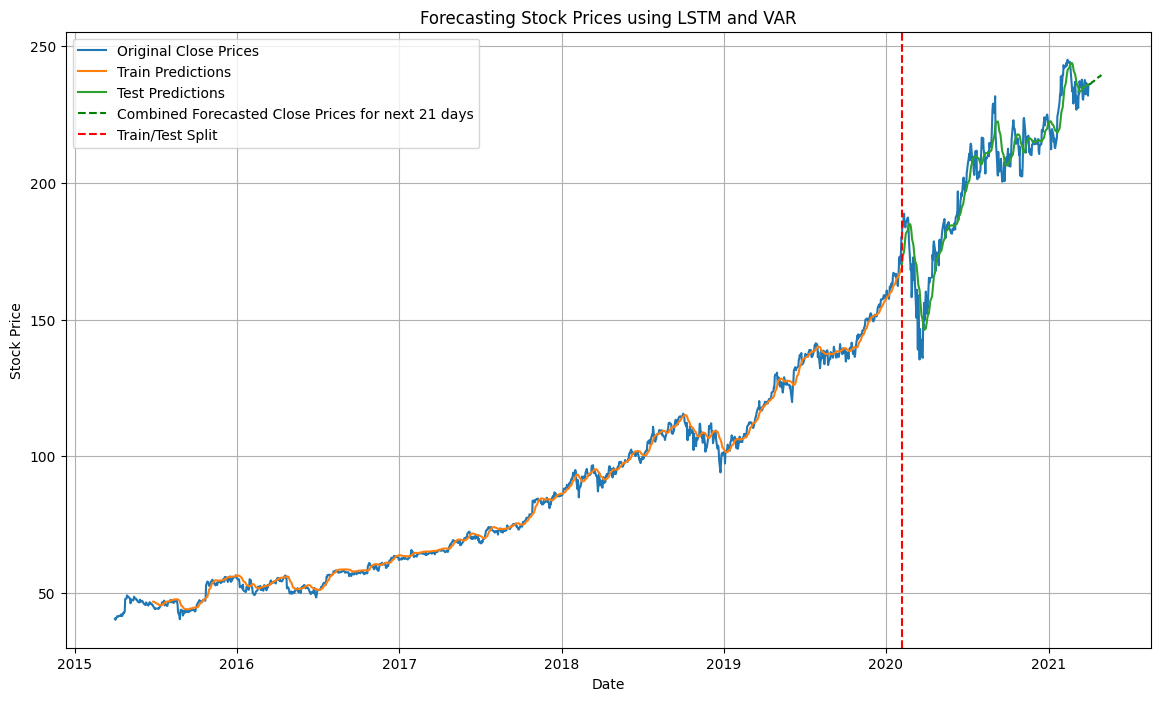

LSTM Forecasted close prices for the next 21 days:
[235.76927 235.88725 236.02916 236.18701 236.35512 236.52972 236.70828
 236.88916 237.07127 237.25406 237.4371  237.62015 237.80312 237.98593
 238.16849 238.35086 238.53293 238.71475 238.89635 239.07764 239.2587 ]
VAR Forecasted close prices for the next 21 days:
[235.98455742 236.1861317  236.37949568 236.56767693 236.75259593
 236.93547093 237.11707469 237.29789741 237.47825007 237.65832991
 237.83826208 238.01812597 238.19797195 238.37783197 238.55772632
 238.73766788 238.91766483 239.09772235 239.27784376 239.45803117
 239.63828591]
Combined Forecasted close prices for the next 21 days:
[235.87691464 236.03669225 236.20432761 236.37734432 236.55385686
 236.73259752 236.91267858 237.09352878 237.27476193 237.45619437
 237.63768268 237.81913684 238.0005439  238.18188168 238.36310694
 238.54426424 238.72529665 238.90623727 239.0870954  239.26783394
 239.44849171]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.api import VAR
from pykalman import KalmanFilter

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    if df.isnull().values.any():
        print("Missing values found. Imputing missing values...")
        df.fillna(method='ffill', inplace=True)

    return df

def apply_kalman_filter(data):
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
    state_means, _ = kf.smooth(data)
    return state_means

def create_lstm_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def suggest_action(forecasted_values, current_price):
    if current_price > forecasted_values[-1]:
        return "sell"
    elif current_price < forecasted_values[-2]:
        return "buy"
    elif all(forecasted_values[i] <= forecasted_values[i + 1] for i in range(len(forecasted_values) - 1)):
        return "buy"
    else:
        return "sell"

def forecast_with_var(df, investment_days):
    model = VAR(df)
    model_fit = model.fit()
    forecast = model_fit.forecast(model_fit.endog[-model_fit.k_ar:], steps=investment_days)
    forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=df.index[-1], periods=investment_days+1, freq='B')[1:], columns=df.columns)
    return forecast_df

def forecast_with_lstm(model, X_test, scaler, time_step, investment_days, last_date):
    lstm_forecasted_values = []
    x_input = X_test[-1]
    for _ in range(investment_days):
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        lstm_forecasted_values.append(yhat[0][0])
        x_input = np.append(x_input[:, 1:, :], yhat.reshape((1, 1, 1)), axis=1)

    lstm_forecasted_values = scaler.inverse_transform(np.array(lstm_forecasted_values).reshape(-1, 1)).flatten()
    forecasted_dates = pd.date_range(start=last_date, periods=investment_days+1, freq='B')[1:]
    lstm_forecast_df = pd.DataFrame(lstm_forecasted_values, index=forecasted_dates, columns=['Close'])
    return lstm_forecast_df

def main(file_path, investment_days):
    df = load_data(file_path)
    ts_close = df[['Close']].values

    # Apply Kalman filter
    ts_close_kalman = apply_kalman_filter(ts_close)

    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    ts_close_scaled = scaler.fit_transform(ts_close_kalman)

    # Create LSTM dataset
    time_step = 60
    X, Y = create_lstm_dataset(ts_close_scaled, time_step)

    # Split into train and test sets
    training_size = int(len(X) * 0.8)
    X_train, X_test = X[:training_size], X[training_size:]
    Y_train, Y_test = Y[:training_size], Y[training_size:]

    # Reshape for LSTM [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Build and train LSTM model
    model = build_lstm_model((X_train.shape[1], 1))
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, batch_size=64, verbose=1, callbacks=[early_stopping])

    # Predict and inverse transform
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Calculate MSE
    mse = mean_squared_error(scaler.inverse_transform(Y_test.reshape(-1, 1)), test_predict)
    print(f'Mean Squared Error (MSE) for LSTM model: {mse:.2f}')

    # Forecasted values using LSTM
    last_date = df.index[-1]
    lstm_forecast_df = forecast_with_lstm(model, X_test, scaler, time_step, investment_days, last_date)

    # VAR forecasting for 'Close' and 'Volume'
    forecasted_df = forecast_with_var(df[['Close', 'Volume']], investment_days)
    var_forecasted_close = forecasted_df['Close'].values
    var_forecasted_volume = forecasted_df['Volume'].values

    # Combine forecasted values
    combined_forecasted_values = (lstm_forecast_df['Close'].values + var_forecasted_close) / 2.0

    # Suggest action based on combined forecasted values
    suggestion = suggest_action(combined_forecasted_values, df['Close'].iloc[-1])
    print(f"Suggestion: {suggestion}")

    # Calculate investment based on current price and combined forecasted values
    current_price = df['Close'].iloc[-1]
    num_stocks = int(input(f"Enter the number of stocks you want to buy based on today's price of Rs. {current_price:.2f}: "))

    investment = num_stocks * current_price
    print(f"Your investment based on today's price: Rs. {investment:.2f}")

    forecasted_last_price = combined_forecasted_values[-1]

    if suggestion == "buy":
        returns = num_stocks * forecasted_last_price - investment
    else:
        profit_per_stock = abs(current_price - forecasted_last_price)
        returns = profit_per_stock * num_stocks + investment

    cumulative_return_after_investment = investment + returns

    if suggestion == "buy":
        print(f"If you follow the suggestion to {suggestion}, your investment of Rs. {investment:.2f} would become Rs. {investment + returns:.2f} after {investment_days} days.")
    else:
        print(f"If you follow the suggestion to {suggestion}, your investment of Rs. {investment:.2f} would become Rs. {cumulative_return_after_investment:.2f} after {investment_days} days.")

    # Plot results
    plt.figure(figsize=(14, 8))
    plt.plot(df.index, df['Close'], label='Original Close Prices')

    # Plot train predictions
    train_predict_plot = np.empty_like(ts_close)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
    plt.plot(df.index, train_predict_plot, label='Train Predictions')

    # Plot test predictions
    test_predict_plot = np.empty_like(ts_close)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict) + time_step:len(ts_close) - 1, :] = test_predict
    plt.plot(df.index, test_predict_plot, label='Test Predictions')

    # Plot combined forecasted values
    forecasted_dates = pd.date_range(df.index[-1], periods=investment_days + 1, freq='B')[1:]  # Generating future dates
    plt.plot(forecasted_dates, combined_forecasted_values, label=f'Combined Forecasted Close Prices for next {investment_days} days', linestyle='--', color='green')

    plt.axvline(x=df.index[training_size + time_step], color='r', linestyle='--', label='Train/Test Split')
    plt.legend()
    plt.title('Forecasting Stock Prices using LSTM and VAR')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.grid(True)
    plt.show()

    print(f"LSTM Forecasted close prices for the next {investment_days} days:\n{lstm_forecast_df['Close'].values}")
    print(f"VAR Forecasted close prices for the next {investment_days} days:\n{var_forecasted_close}")
    print(f"Combined Forecasted close prices for the next {investment_days} days:\n{combined_forecasted_values}")

    return lstm_forecast_df, forecasted_df, combined_forecasted_values

# Main execution
investment_days = int(input("Enter the number of days you want to invest in this stock: "))
lstm_forecast_df, var_forecast_df, combined_forecasted_values = main('MS.csv', investment_days)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.api import VAR
from pykalman import KalmanFilter

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    if df.isnull().values.any():
        print("Missing values found. Imputing missing values...")
        df.fillna(method='ffill', inplace=True)

    return df

def apply_kalman_filter(data):
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
    state_means, _ = kf.smooth(data)
    return state_means

def create_lstm_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def suggest_action(forecasted_values, current_price):
    if current_price > forecasted_values[-1]:
        return "sell"
    elif current_price < forecasted_values[-2]:
        return "buy"
    elif all(forecasted_values[i] <= forecasted_values[i + 1] for i in range(len(forecasted_values) - 1)):
        return "buy"
    else:
        return "sell"

def forecast_with_var(df, investment_days):
    model = VAR(df)
    model_fit = model.fit()
    forecast = model_fit.forecast(model_fit.endog[-model_fit.k_ar:], steps=investment_days)
    forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=df.index[-1], periods=investment_days+1, freq='B')[1:], columns=df.columns)
    return forecast_df

def forecast_with_lstm(model, X_test, scaler, time_step, investment_days, last_date):
    lstm_forecasted_values = []
    x_input = X_test[-1]
    for _ in range(investment_days):
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        lstm_forecasted_values.append(yhat[0][0])
        x_input = np.append(x_input[:, 1:, :], yhat.reshape((1, 1, 1)), axis=1)

    lstm_forecasted_values = scaler.inverse_transform(np.array(lstm_forecasted_values).reshape(-1, 1)).flatten()
    forecasted_dates = pd.date_range(start=last_date, periods=investment_days+1, freq='B')[1:]
    lstm_forecast_df = pd.DataFrame(lstm_forecasted_values, index=forecasted_dates, columns=['Close'])
    return lstm_forecast_df

def main(file_path, investment_days):
    df = load_data(file_path)
    ts_close = df[['Close']].values

    # Apply Kalman filter
    ts_close_kalman = apply_kalman_filter(ts_close)

    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    ts_close_scaled = scaler.fit_transform(ts_close_kalman)

    # Create LSTM dataset
    time_step = 60
    X, Y = create_lstm_dataset(ts_close_scaled, time_step)

    # Split into train and test sets
    training_size = int(len(X) * 0.8)
    X_train, X_test = X[:training_size], X[training_size:]
    Y_train, Y_test = Y[:training_size], Y[training_size:]

    # Reshape for LSTM [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Build and train LSTM model
    model = build_lstm_model((X_train.shape[1], 1))
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, batch_size=64, verbose=1, callbacks=[early_stopping])

    # Predict and inverse transform
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Calculate MSE
    mse = mean_squared_error(scaler.inverse_transform(Y_test.reshape(-1, 1)), test_predict)
    print(f'Mean Squared Error (MSE) for LSTM model: {mse:.2f}')

    # Forecasted values using LSTM
    last_date = df.index[-1]
    lstm_forecast_df = forecast_with_lstm(model, X_test, scaler, time_step, investment_days, last_date)

    # VAR forecasting for 'Close' and 'Volume'
    forecasted_df = forecast_with_var(df[['Close', 'Volume']], investment_days)
    var_forecasted_close = forecasted_df['Close'].values
    var_forecasted_volume = forecasted_df['Volume'].values

    # Combine forecasted values
    combined_forecasted_values = (lstm_forecast_df['Close'].values + var_forecasted_close) / 2.0

    # Suggest action based on combined forecasted values
    suggestion = suggest_action(combined_forecasted_values, df['Close'].iloc[-1])
    print(f"Suggestion: {suggestion}")

    # Calculate investment based on current price and combined forecasted values
    current_price = df['Close'].iloc[-1]
    num_stocks = int(input(f"Enter the number of stocks you want to buy based on today's price of Rs. {current_price:.2f}: "))

    investment = num_stocks * current_price
    print(f"Your investment based on today's price: Rs. {investment:.2f}")

    forecasted_last_price = combined_forecasted_values[-1]

    if suggestion == "buy":
        returns = num_stocks * forecasted_last_price - investment
    else:
        profit_per_stock = abs(current_price - forecasted_last_price)
        returns = profit_per_stock * num_stocks + investment

    cumulative_return_after_investment = investment + returns

    if suggestion == "buy":
        print(f"If you follow the suggestion to {suggestion}, your investment of Rs. {investment:.2f} would become Rs. {investment + returns:.2f} after {investment_days} days.")
    else:
        print(f"If you follow the suggestion to {suggestion}, your investment of Rs. {investment:.2f} would become Rs. {cumulative_return_after_investment:.2f} after {investment_days} days.")

    # Plot results
    plt.figure(figsize=(14, 8))
    plt.plot(df.index, df['Close'], label='Original Close Prices')

    # Plot train predictions
    train_predict_plot = np.empty_like(ts_close)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict
    plt.plot(df.index, train_predict_plot, label='Train Predictions')

    # Plot test predictions
    test_predict_plot = np.empty_like(ts_close)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict) + time_step:len(ts_close) - 1, :] = test_predict
    plt.plot(df.index, test_predict_plot, label='Test Predictions')

    # Plot LSTM forecasted values
    plt.plot(lstm_forecast_df.index, lstm_forecast_df['Close'], label=f'LSTM Forecasted Close Prices for next {investment_days} days', linestyle='--', color='blue')

    # Plot VAR forecasted values
    plt.plot(forecasted_df.index, forecasted_df['Close'], label=f'VAR Forecasted Close Prices for next {investment_days} days', linestyle='--', color='orange')

    # Plot combined forecasted values
    forecasted_dates = pd.date_range(df.index[-1], periods=investment_days + 1, freq='B')[1:]  # Generating future dates
    plt.plot(forecasted_dates, combined_forecasted_values, label=f'Combined Forecasted Close Prices for next {investment_days} days', linestyle='--', color='green')

    plt.axvline(x=df.index[training_size + time_step], color='r', linestyle='--', label='Train/Test Split')
    plt.legend()
    plt.title('Forecasting Stock Prices using LSTM and VAR')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.grid(True)
    plt.show()

    print(f"LSTM Forecasted close prices for the next {investment_days} days:\n{lstm_forecast_df['Close'].values}")
    print(f"VAR Forecasted close prices for the next {investment_days} days:\n{var_forecasted_close}")
    print(f"Combined Forecasted close prices for the next {investment_days} days:\n{combined_forecasted_values}")

    return lstm_forecast_df, forecasted_df, combined_forecasted_values

# Main execution
investment_days = int(input("Enter the number of days you want to invest in this stock: "))
lstm_forecast_df, var_forecast_df, combined_forecasted_values = main('MS.csv', investment_days)


Enter the number of days you want to invest in this stock: 100
Epoch 1/200
19/19 [==============================] - 11s 334ms/step - loss: 0.0154 - val_loss: 0.0014
Epoch 2/200
19/19 [==============================] - 4s 217ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 3/200
19/19 [==============================] - 3s 180ms/step - loss: 9.0535e-04 - val_loss: 0.0014
Epoch 4/200
19/19 [==============================] - 3s 173ms/step - loss: 7.6605e-04 - val_loss: 0.0011
Epoch 5/200
19/19 [==============================] - 5s 263ms/step - loss: 7.4110e-04 - val_loss: 0.0011
Epoch 6/200
19/19 [==============================] - 3s 168ms/step - loss: 6.4167e-04 - val_loss: 0.0013
Epoch 7/200
19/19 [==============================] - 3s 172ms/step - loss: 5.9341e-04 - val_loss: 0.0015
Epoch 8/200
19/19 [==============================] - 4s 193ms/step - loss: 6.9825e-04 - val_loss: 0.0016
Epoch 9/200
19/19 [==============================] - 6s 320ms/step - loss: 7.0352e-04 - val_loss: 0.0015

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Suggestion: buy
Enter the number of stocks you want to buy based on today's price of Rs. 235.77: 21
Your investment based on today's price: Rs. 4951.17
If you follow the suggestion to buy, your investment of Rs. 4951.17 would become Rs. 5551.79 after 100 days.


LSTM Forecasted close prices for the next 100 days:
[236.73563 236.90836 237.14662 237.42825 237.73824 238.06638 238.40602
 238.75276 239.10394 239.45789 239.81367 240.1707  240.52867 240.88751
 241.2471  241.60753 241.96866 242.33066 242.69342 243.05705 243.42148
 243.78674 244.15291 244.5199  244.88777 245.25648 245.62602 245.99646
 246.36775 246.73988 247.11287 247.48666 247.86136 248.23691 248.61325
 248.99039 249.36842 249.74727 250.12692 250.50743 250.88876 251.27084
 251.65381 252.03754 252.42204 252.80739 253.19353 253.58038 253.96811
 254.35654 254.7458  255.1358  255.52655 255.91809 256.31042 256.70337
 257.09717 257.4917  257.88693 258.28287 258.67953 259.07693 259.47507
 259.8738  260.27338 260.6735  261.0744  261.47598 261.87814 262.2811
 262.6846  263.08884 263.49365 263.89908 264.30527 264.71198 265.11932
 265.52728 265.93585 266.345   266.7547  267.1651  267.57602 267.98752
 268.3994  268.81204 269.22516 269.6388  270.05295 270.46765 270.88284
 271.29855 271.71475 272.1

In [ ]:
!pip install pykalman


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 5.2 MB/s eta 0:00:00
